# ARK-LA-TEX Precipitation Variability and EOF Analysis  
### Nicholas Ruprecht — ATMS 523 Final Project

This project analyzes precipitation variability in the ARK-LA-TEX region (Arkansas, Louisiana, Texas) using the **NOAA Global Historical Climatology Network Daily (GHCN-D)** dataset [https://doi.org/10.7289/V5D21VHZ].  
The workflow spans 1870–2020, focusing on annual, seasonal, and decadal precipitation anomalies, rolling variability, and Empirical Orthogonal Function (EOF) analysis.  
All results are reproducible and documented with Python, xarray, cartopy, and scikit-learn.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from eofs.xarray import Eof

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

print("Setup complete.")


Setup complete.


In [2]:
# NOAA GHCN Station Metadata

stn_ids = pd.read_fwf(
    'http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt', 
    header=None, infer_nrows=10000
)
stn_ids.columns = ['ID','LAT','LON','ELEV','UKN','NAME','GSN','WBAN']

# Filter for ARK-LA-TEX region
lat_min, lat_max = 32, 35
lon_min, lon_max = -94.1, -92
region_stations = stn_ids[
    (stn_ids['LAT'] >= lat_min) & (stn_ids['LAT'] <= lat_max) &
    (stn_ids['LON'] >= lon_min) & (stn_ids['LON'] <= lon_max)
]

print(f"Selected {len(region_stations)} stations in ARK-LA-TEX region")
region_stations[['ID','NAME','LAT','LON']]


Selected 495 stations in ARK-LA-TEX region


,ID,NAME,LAT,LON
55287,US1ARCK0002,ARKADELPHIA 7.8 NNE,34.2226,-93.0039
55288,US1ARCK0004,ARKADELPHIA 0.8 NNW,34.1341,-93.0787
55289,US1ARCK0007,ARKADELPHIA 2.4 NW,34.1448,-93.1031
55290,US1ARCK0008,ARKADELPHIA 8.5 ESE,34.0675,-92.9382
55291,US1ARCK0010,GURDON 0.6 NE,33.9229,-93.1422
...,...,...,...,...
127526,USW00013977,TEXARKANA WEBB FLD,33.4561,-93.9878
128294,USW00053905,SHREVEPORT DWTN AP,32.5397,-93.7461
128309,USW00053921,MT IDA,34.5467,-93.5781
128323,USW00053961,MONROE 26 N,32.8833,-92.1164


In [3]:
# precipitation data

station_dfs = []

for station_id in region_stations['ID']:
    try:
        df = pd.read_parquet(
            f"s3://noaa-ghcn-pds/parquet/by_station/STATION={station_id}/",
            storage_options={"anon": True}
        )
        df['DATE'] = pd.to_datetime(df['DATE'].astype(str), format='%Y%m%d')
        df = df.set_index('DATE').sort_index()
        df_precip = df[df['ELEMENT']=='PRCP'][['DATA_VALUE']].rename(columns={'DATA_VALUE': station_id})
        station_dfs.append(df_precip)
        print(f"Loaded {station_id}")
    except Exception as e:
        print(f"Skipping {station_id} due to error: {e}")

# Combining all stations
if station_dfs:
    precip_all = pd.concat(station_dfs, axis=1)
    # Converting from hundredths of mm to mm
    precip_all = precip_all / 10
    print("All station data combined.")
else:
    raise ValueError("No stations were successfully loaded.")


Loaded US1ARCK0002
Loaded US1ARCK0004
Loaded US1ARCK0007
Loaded US1ARCK0008
Loaded US1ARCK0010
Loaded US1ARCM0003
Loaded US1ARCM0004
Loaded US1ARCM0005
Loaded US1ARCM0009
Loaded US1ARCN0001
Loaded US1ARCN0002
Loaded US1ARCN0003
Loaded US1ARCN0006
Loaded US1ARCN0007
Loaded US1ARDL0001
Loaded US1ARDL0004
Loaded US1ARFK0005
Loaded US1ARFK0008
Loaded US1ARFK0023
Loaded US1ARGL0001
Loaded US1ARGL0003
Loaded US1ARGL0004
Loaded US1ARGL0005
Loaded US1ARGL0008
Loaded US1ARGL0009
Loaded US1ARGL0011
Loaded US1ARGL0016
Loaded US1ARGL0017
Loaded US1ARGL0018
Loaded US1ARGL0021
Loaded US1ARGL0023
Loaded US1ARGL0026
Loaded US1ARGL0029
Loaded US1ARGL0031
Loaded US1ARGL0032
Loaded US1ARGL0034
Loaded US1ARGL0036
Loaded US1ARGL0039
Loaded US1ARGT0002
Loaded US1ARGT0003
Loaded US1ARGT0004
Loaded US1ARGT0006
Loaded US1ARGT0009
Loaded US1ARHM0002
Loaded US1ARHM0003
Loaded US1ARHM0005
Loaded US1ARHM0006
Loaded US1ARHM0007
Loaded US1ARHM0013
Loaded US1ARHS0001
Loaded US1ARHS0006
Loaded US1ARHS0008
Loaded US1AR

In [4]:
# Averaging Precipitation Across Stations

precip_mean = precip_all.mean(axis=1, skipna=True)
precip_mean = precip_mean.rename("ARKLA_TEX_avg_precip")
precip_mean.head()


DATE
1872-02-01     2.0
1872-02-02     0.0
1872-02-03     0.0
1872-02-04     0.0
1872-02-05    38.1
Name: ARKLA_TEX_avg_precip, dtype: float64

In [5]:
# Computing decadal averages
# Resampling monthly precipitation

monthly_precip = precip_all.resample('M').mean()
monthly_precip = monthly_precip.dropna(how='all')
print("Monthly precip shape:", monthly_precip.shape)

decades = [(year, year+9) for year in range(1900, 2020, 10)]
decade_labels = [f"{start}-{end}" for start, end in decades]

decade_means = {}
for label, (start, end) in zip(decade_labels, decades):
    start_date = f"{start}-01-01"
    end_date = f"{end}-12-31"
    subset = monthly_precip.loc[start_date:end_date]
    decade_means[label] = subset.mean()

decade_means_df = pd.DataFrame(decade_means).T
print(decade_means_df.head())


Monthly precip shape: (1840, 495)
           US1ARCK0002  US1ARCK0004  US1ARCK0007  US1ARCK0008  US1ARCK0010  \
1900-1909          NaN          NaN          NaN          NaN          NaN   
1910-1919          NaN          NaN          NaN          NaN          NaN   
1920-1929          NaN          NaN          NaN          NaN          NaN   
1930-1939          NaN          NaN          NaN          NaN          NaN   
1940-1949          NaN          NaN          NaN          NaN          NaN   

           US1ARCM0003  US1ARCM0004  US1ARCM0005  US1ARCM0009  US1ARCN0001  \
1900-1909          NaN          NaN          NaN          NaN          NaN   
1910-1919          NaN          NaN          NaN          NaN          NaN   
1920-1929          NaN          NaN          NaN          NaN          NaN   
1930-1939          NaN          NaN          NaN          NaN          NaN   
1940-1949          NaN          NaN          NaN          NaN          NaN   

           ...  USW00003962 

In [6]:
# Computing anomalies relative to overall mean

overall_mean = decade_means_df.mean(axis=0)
anomalies = decade_means_df - overall_mean

# Interpolation grid
from scipy.interpolate import griddata

grid_res = 0.05
lon_min, lon_max = region_stations['LON'].min()-0.1, region_stations['LON'].max()+0.1
lat_min, lat_max = region_stations['LAT'].min()-0.1, region_stations['LAT'].max()+0.1
grid_lon, grid_lat = np.meshgrid(
    np.arange(lon_min, lon_max, grid_res),
    np.arange(lat_min, lat_max, grid_res)
)

# Interpolating each decade
anomalies_interp = {}
for decade in anomalies.index:
    lons, lats, values = [], [], []
    for station_id, value in anomalies.loc[decade].items():
        if np.isnan(value):
            continue
        row = region_stations[region_stations['ID'] == station_id]
        if row.empty:
            continue
        lons.append(row['LON'].values[0])
        lats.append(row['LAT'].values[0])
        values.append(value)
    if len(values) == 0:
        anomalies_interp[decade] = np.full(grid_lon.shape, np.nan)
        continue
    anomalies_interp[decade] = griddata(
        points=(np.array(lons), np.array(lats)),
        values=np.array(values),
        xi=(grid_lon, grid_lat),
        method='cubic'
    )


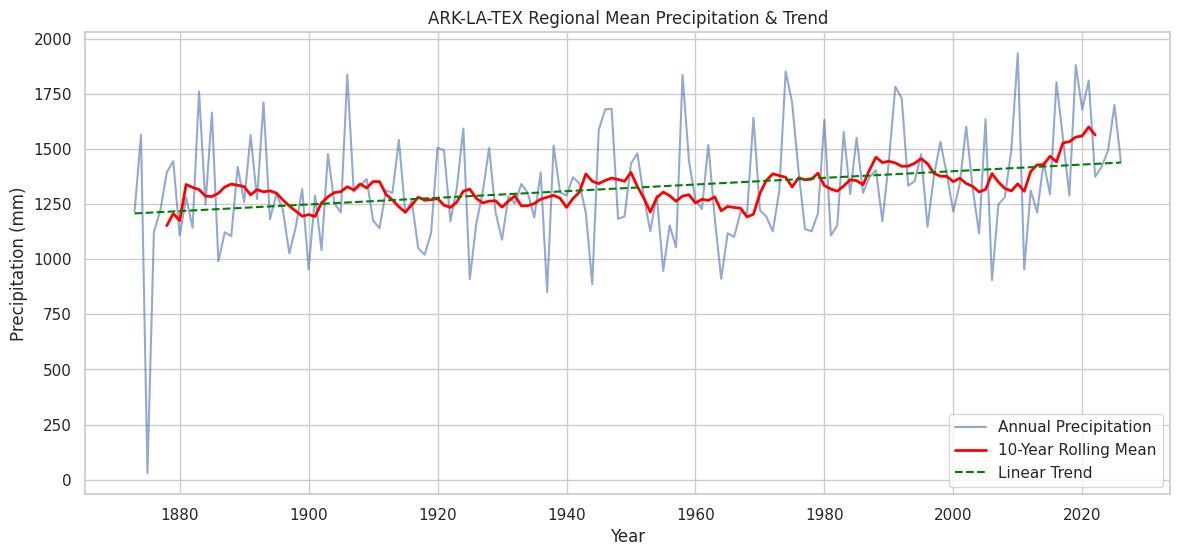

In [7]:
# Regional Mean Time Series

regional_mean = precip_all.mean(axis=1, skipna=True)

annual_precip = regional_mean.resample('A').sum()
rolling_precip = annual_precip.rolling(window=10, center=True).mean()  # 10-year rolling mean

years = annual_precip.index.year.values.reshape(-1,1)
lin_model = LinearRegression()
lin_model.fit(years, annual_precip.values)
trend_line = lin_model.predict(years)

plt.figure(figsize=(14,6))
plt.plot(annual_precip.index, annual_precip, label='Annual Precipitation', alpha=0.6)
plt.plot(annual_precip.index, rolling_precip, label='10-Year Rolling Mean', color='red', linewidth=2)
plt.plot(annual_precip.index, trend_line, '--', color='green', label='Linear Trend')
plt.title("ARK-LA-TEX Regional Mean Precipitation & Trend")
plt.xlabel("Year")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.grid(True)
plt.show()


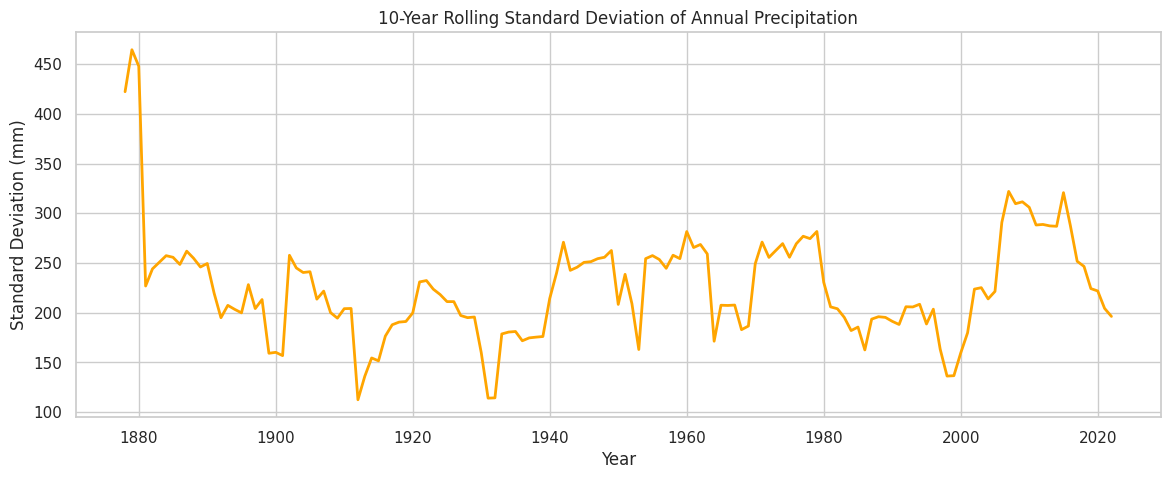

In [8]:
# Rolling variability (10-year)

rolling_std = annual_precip.rolling(window=10, center=True).std()

plt.figure(figsize=(14,5))
plt.plot(rolling_std.index, rolling_std, color='orange', linewidth=2)
plt.title("10-Year Rolling Standard Deviation of Annual Precipitation")
plt.xlabel("Year")
plt.ylabel("Standard Deviation (mm)")
plt.grid(True)
plt.show()


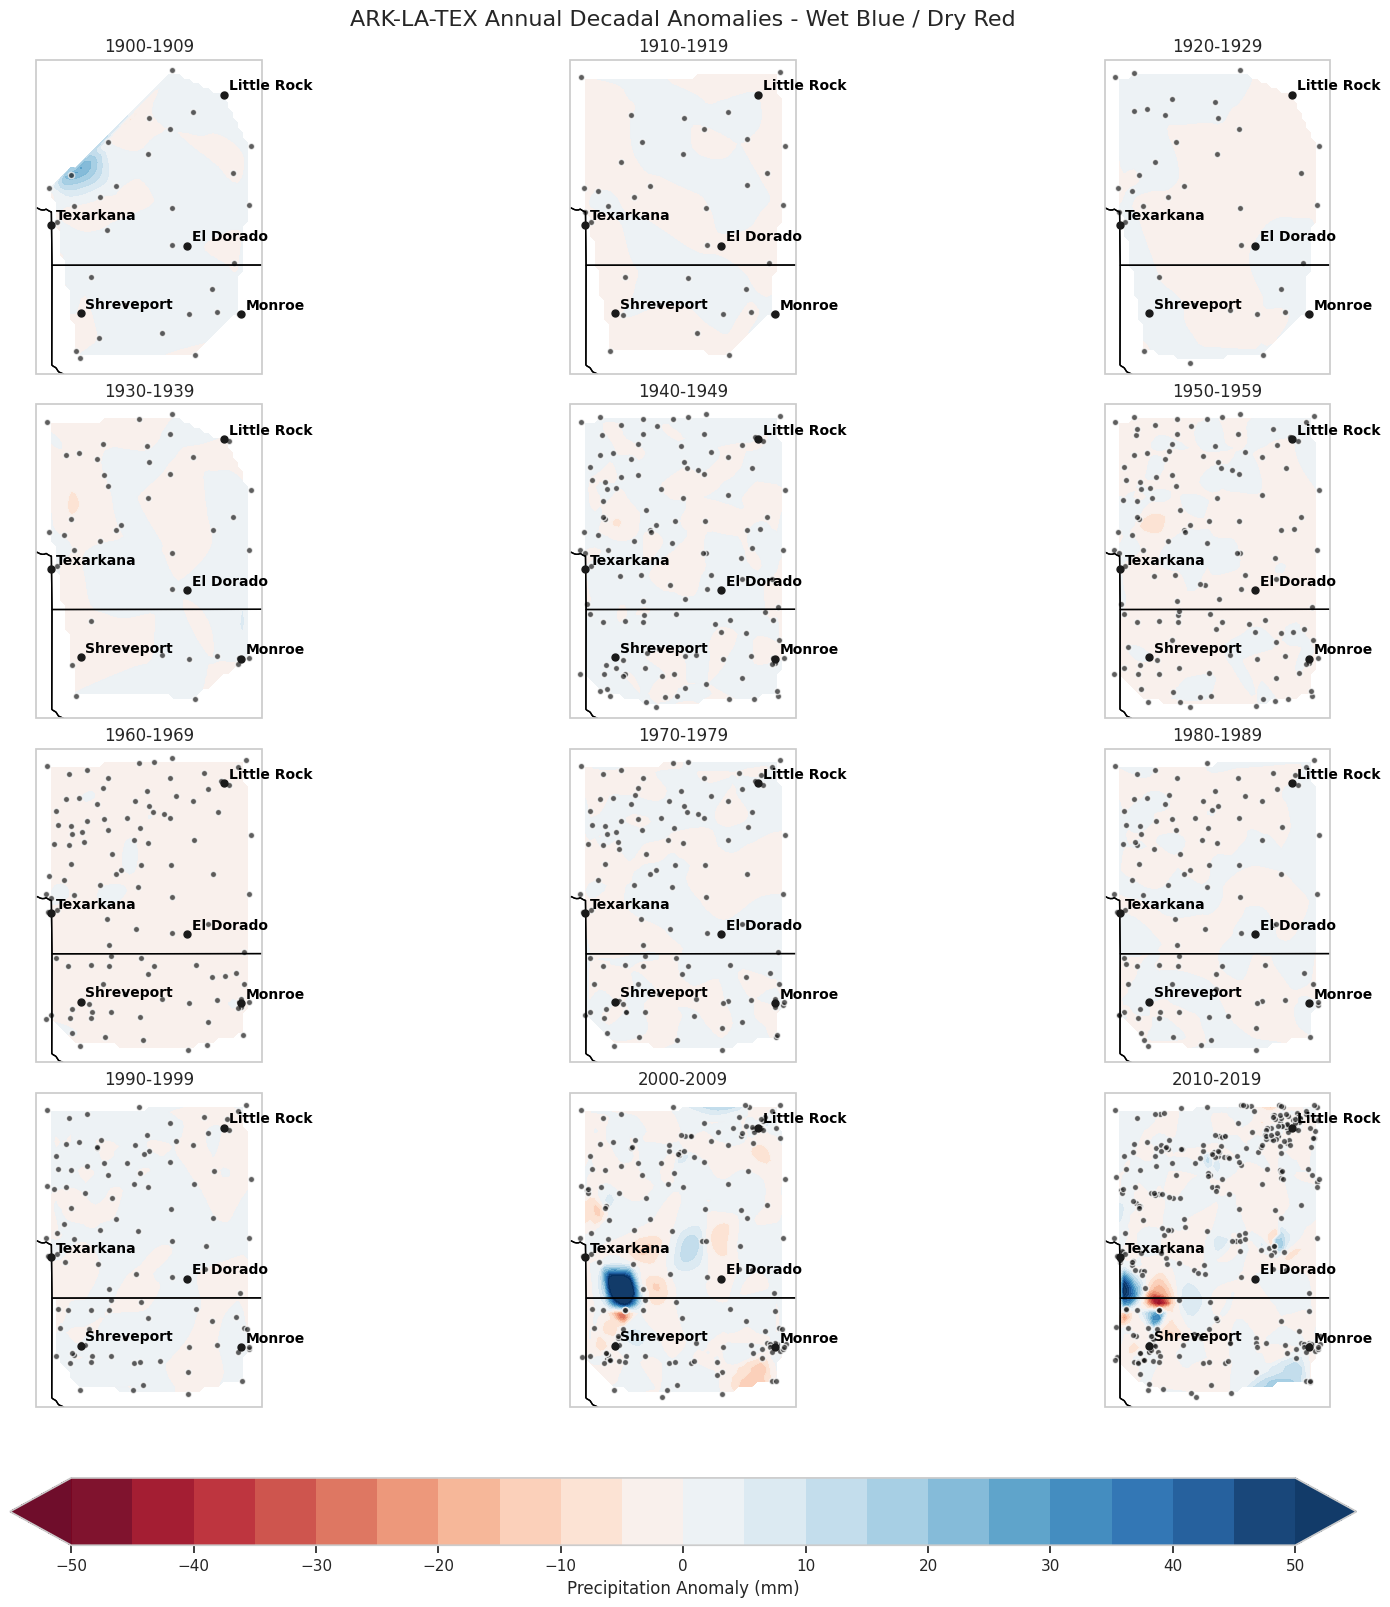

In [9]:
import matplotlib.colors as mcolors

class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint
        rescaled = np.ma.masked_array((result - midpoint) / (vmax - vmin) + 0.5)
        return rescaled
        
# Plotting all decades with enhanced contrast

n_cols = 3
num_decades = len(decade_labels)
n_rows = int(np.ceil(num_decades / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows),
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         constrained_layout=True)
axes = axes.flatten()

# Enhanced contrast parameters
max_anom = 50  
levels = np.arange(-max_anom, max_anom+5, 5) 
cmap = plt.get_cmap('RdBu')  
norm = MidpointNormalize(vmin=-max_anom, vmax=max_anom, midpoint=0)

major_cities = {
    "Little Rock": (34.7465, -92.2896),
    "Shreveport": (32.5252, -93.7502),
    "Texarkana": (33.4251, -94.0477),
    "Monroe": (32.5093, -92.1193),
    "El Dorado": (33.2088, -92.6673)
}

for ax, decade in zip(axes, decade_labels):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Contouring filled anomaly with normalization
    cf = ax.contourf(grid_lon, grid_lat, anomalies_interp[decade],
                     levels=levels, cmap=cmap, norm=norm, extend='both', alpha=0.95)

    station_vals = anomalies.loc[decade]
    for station_id, val in station_vals.items():
        row = region_stations[region_stations['ID'] == station_id]
        if row.empty or np.isnan(val):
            continue
        ax.scatter(row['LON'].values[0], row['LAT'].values[0],
                   s=20, c='k', edgecolor='white', alpha=0.7)

    for city, (lat, lon) in major_cities.items():
        ax.plot(lon, lat, 'ko', markersize=5)
        ax.text(lon+0.05, lat+0.05, city, fontsize=10, weight='bold', color='black')

    ax.set_title(f"{decade}", fontsize=12)

for ax in axes[num_decades:]:
    ax.axis('off')

cbar = fig.colorbar(cf, ax=axes[:num_decades], orientation='horizontal', pad=0.05, fraction=0.05)
cbar.set_label("Precipitation Anomaly (mm)", fontsize=12)
cbar.set_ticks(np.arange(-max_anom, max_anom+10, 10))

fig.suptitle("ARK-LA-TEX Annual Decadal Anomalies - Wet Blue / Dry Red", fontsize=16)
plt.show()


Season with highest variability overall: MAM


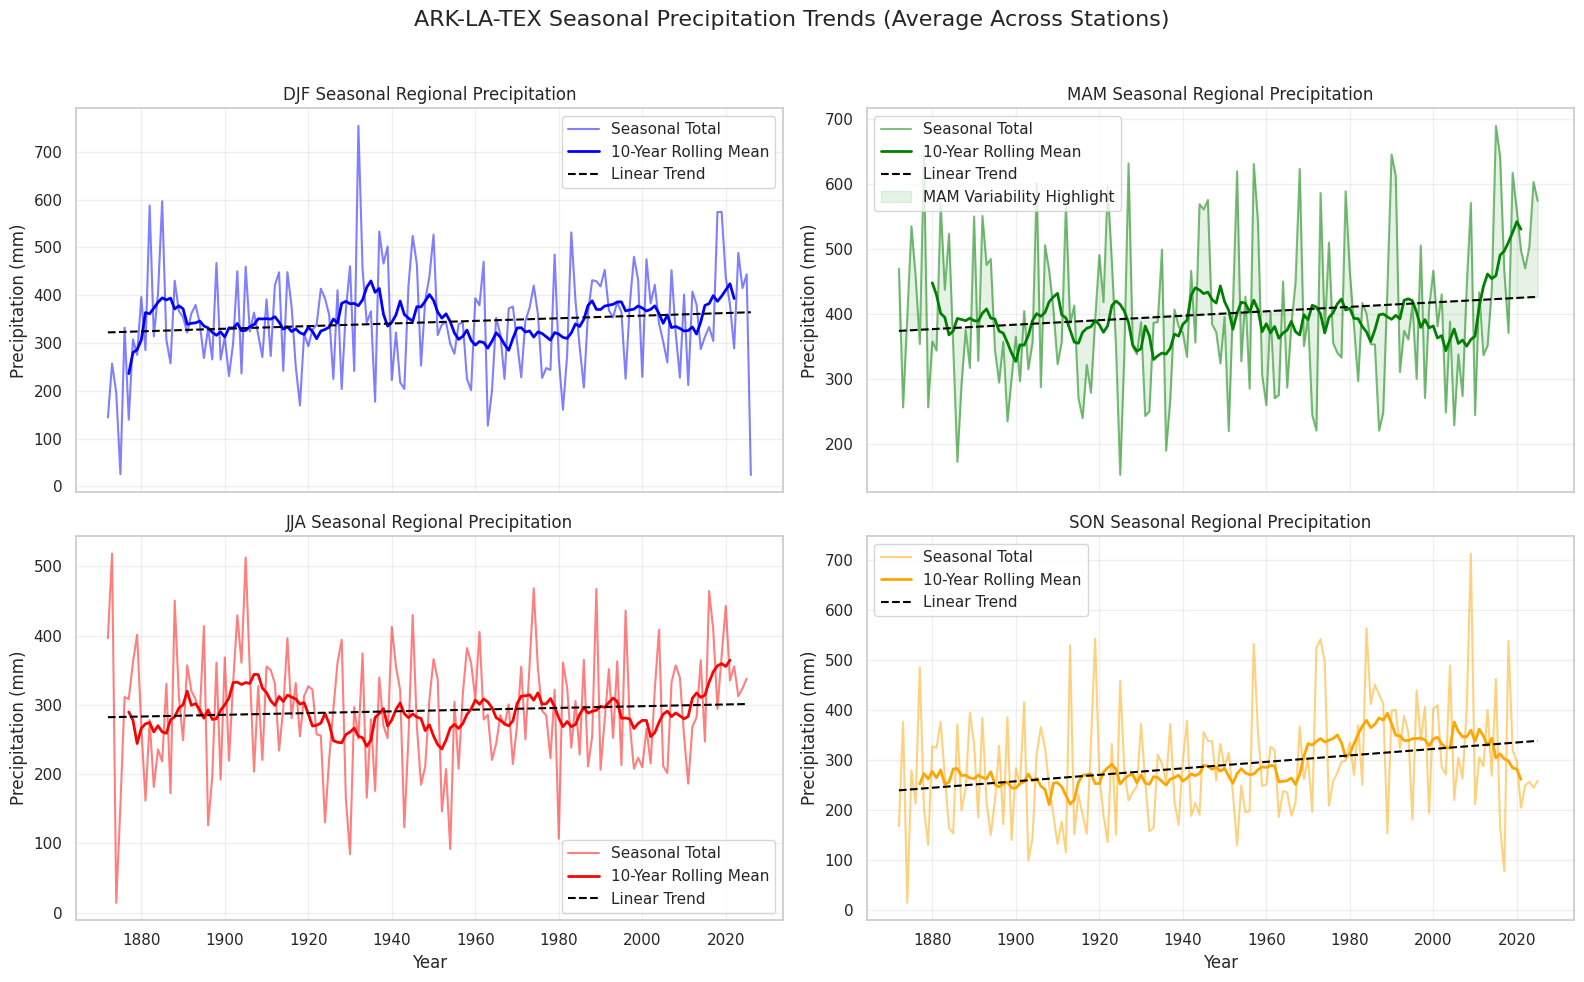

In [10]:
# Seasonal Precipitation Trends

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def get_season(month):
    if month in [12, 1, 2]:
        return 'DJF'
    elif month in [3, 4, 5]:
        return 'MAM'
    elif month in [6, 7, 8]:
        return 'JJA'
    elif month in [9, 10, 11]:
        return 'SON'

monthly_avg = precip_all.mean(axis=1, skipna=True)
season_series = pd.DataFrame({'Precip': monthly_avg})
season_series['Month'] = season_series.index.month
season_series['Year'] = season_series.index.year
season_series['Season'] = season_series['Month'].map(get_season)

season_series.loc[season_series['Month'] == 12, 'Year'] += 1

seasonal_totals = season_series.groupby(['Year', 'Season'])['Precip'].sum().unstack()

# 10-year rolling mean
seasonal_rolling = seasonal_totals.rolling(window=10, center=True).mean()

# Identifying season with highest variability
season_std = seasonal_totals.std()
max_var_season = season_std.idxmax()
print("Season with highest variability overall:", max_var_season)

fig, axes = plt.subplots(2, 2, figsize=(16,10), sharex=True)
axes = axes.flatten()
colors = {'DJF':'blue', 'MAM':'green', 'JJA':'red', 'SON':'orange'}

for i, season in enumerate(['DJF','MAM','JJA','SON']):
    ax = axes[i]
    
    y = seasonal_totals[season].dropna()
    x = y.index.values.reshape(-1,1)

    ax.plot(y.index, y.values, alpha=0.5, color=colors[season], label='Seasonal Total')

    # 10-year rolling mean
    rolling_y = seasonal_rolling[season].reindex(y.index)
    ax.plot(rolling_y.index, rolling_y.values, color=colors[season], linewidth=2, label='10-Year Rolling Mean')

    # Linear trend
    lin_model = LinearRegression()
    lin_model.fit(x, y.values)
    trend_line = lin_model.predict(x)
    ax.plot(y.index, trend_line, '--', color='black', label='Linear Trend')

    if season == max_var_season:
        ax.fill_between(y.index, y.values, trend_line, color='green', alpha=0.1, label=f'{season} Variability Highlight')

    ax.set_title(f"{season} Seasonal Regional Precipitation", fontsize=12)
    ax.set_ylabel("Precipitation (mm)")
    ax.grid(True, alpha=0.3)
    ax.legend()

for ax in axes[2:]:
    ax.set_xlabel("Year")

plt.suptitle("ARK-LA-TEX Seasonal Precipitation Trends (Average Across Stations)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


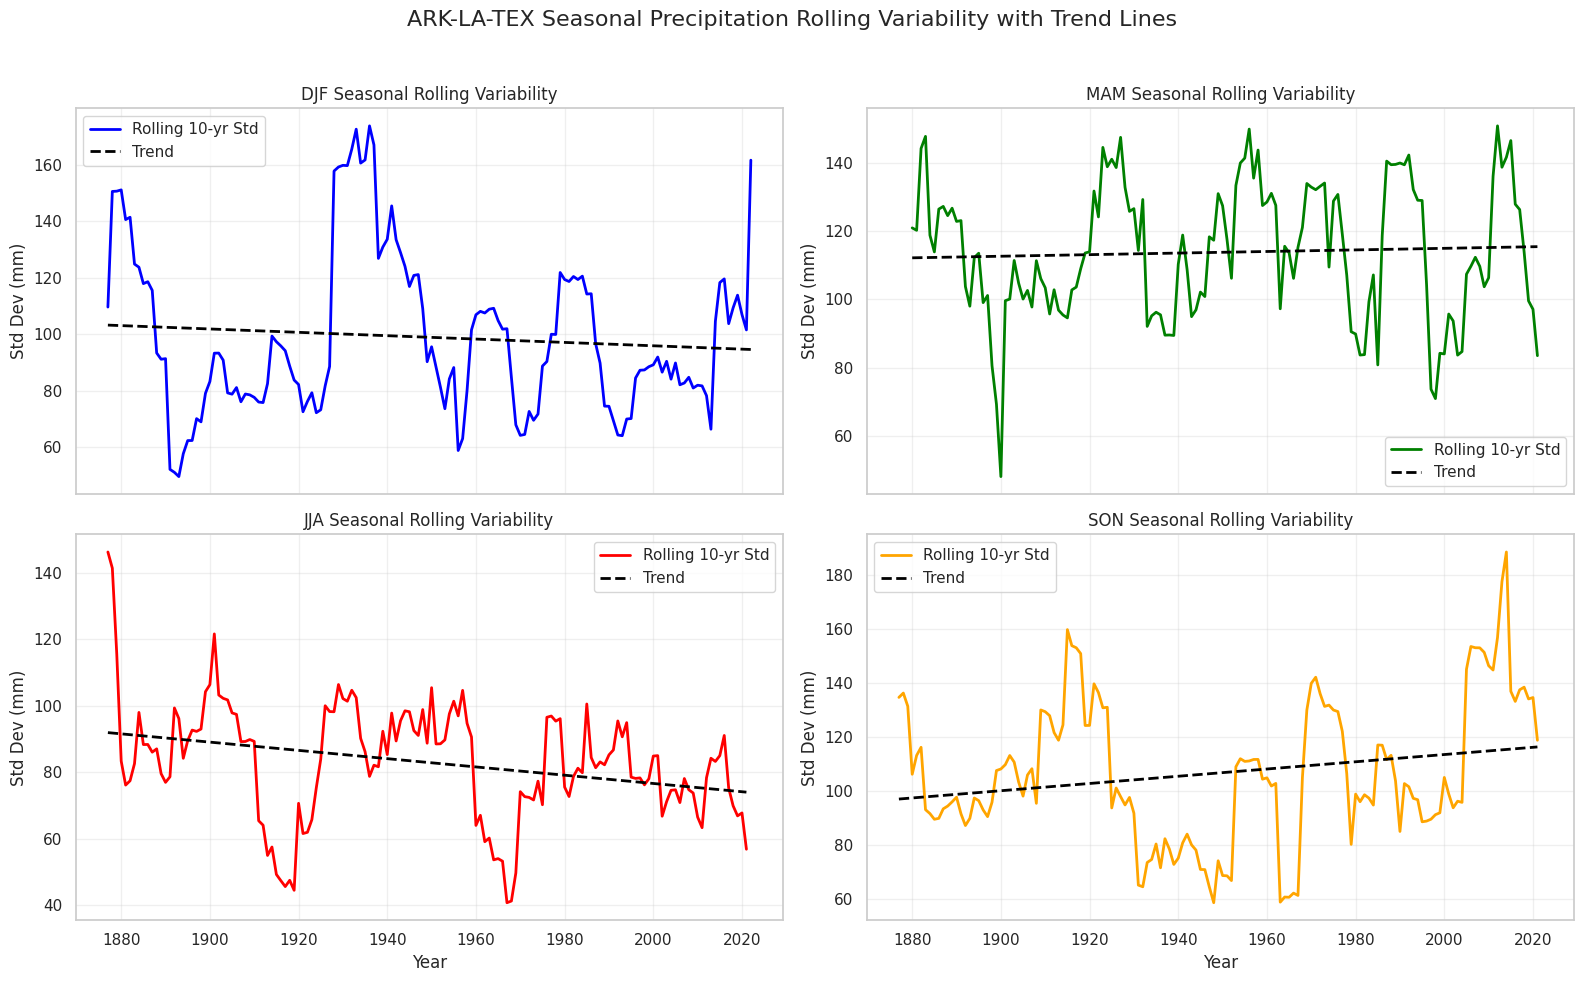

In [11]:
# Seasonal Rolling Variability with Trend Lines

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

monthly_total = precip_all.sum(axis=1, skipna=True)
n_stations = precip_all.notna().sum(axis=1)
monthly_avg = monthly_total / n_stations

season_series = pd.DataFrame({'Precip': monthly_avg})
season_series['Month'] = season_series.index.month
season_series['Year'] = season_series.index.year

def get_season(month):
    if month in [12,1,2]:
        return 'DJF'
    elif month in [3,4,5]:
        return 'MAM'
    elif month in [6,7,8]:
        return 'JJA'
    elif month in [9,10,11]:
        return 'SON'

season_series['Season'] = season_series['Month'].map(get_season)

season_series.loc[season_series['Month'] == 12, 'Year'] += 1

seasonal_totals = season_series.groupby(['Year','Season'])['Precip'].sum().unstack()  # seasons as columns

rolling_std = seasonal_totals.rolling(window=10, center=True).std()

fig, axes = plt.subplots(2, 2, figsize=(16,10), sharex=True)
axes = axes.flatten()
colors = {'DJF':'blue', 'MAM':'green', 'JJA':'red', 'SON':'orange'}

for i, season in enumerate(['DJF','MAM','JJA','SON']):
    ax = axes[i]
    y = rolling_std[season]
 
    ax.plot(rolling_std.index, y, color=colors[season], linewidth=2, label='Rolling 10-yr Std')
    
    # Fitting trend line, dropping NaNs
    y_valid = y.dropna()
    if len(y_valid) > 1:
        X = y_valid.index.values.reshape(-1,1)  
        model = LinearRegression()
        model.fit(X, y_valid.values)
        y_trend = model.predict(X)
        ax.plot(y_valid.index, y_trend, color='black', linestyle='--', linewidth=2, label='Trend')
    
    ax.set_title(f"{season} Seasonal Rolling Variability", fontsize=12)
    ax.set_ylabel("Std Dev (mm)")
    ax.grid(True, alpha=0.3)
    ax.legend()

for ax in axes[2:]:
    ax.set_xlabel("Year")

plt.suptitle("ARK-LA-TEX Seasonal Precipitation Rolling Variability with Trend Lines", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


In [12]:
# MAM Seasonal Decadal Anomalies 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata

def get_season(month):
    if month in [12, 1, 2]:
        return 'DJF'
    elif month in [3, 4, 5]:
        return 'MAM'
    elif month in [6, 7, 8]:
        return 'JJA'
    elif month in [9, 10, 11]:
        return 'SON'

seasonal_precip = precip_all.copy()
seasonal_precip['Season'] = seasonal_precip.index.month.map(get_season)
seasonal_precip['Year'] = seasonal_precip.index.year

seasonal_precip.loc[seasonal_precip.index.month == 12, 'Year'] += 1

# Focusing only on MAM
season = 'MAM'
decade_labels = [f"{start}-{start+9}" for start in range(1900, 2020, 10)]
seasonal_decade_means = pd.DataFrame(index=region_stations['ID'], columns=decade_labels)

for start in range(1900, 2020, 10):
    end = start + 9
    start_date = f"{start}-01-01"
    end_date = f"{end}-12-31"
    subset = seasonal_precip.loc[start_date:end_date]
    
    season_subset = subset[subset['Season'] == season].drop(columns=['Season','Year'])
    seasonal_decade_means[f"{start}-{end}"] = season_subset.sum() / len(season_subset.columns)

overall_mean = seasonal_decade_means.mean(axis=1)
seasonal_anomalies = seasonal_decade_means.subtract(overall_mean, axis=0)


# Interpolation grid
grid_res = 0.05
lon_min, lon_max = region_stations['LON'].min()-0.1, region_stations['LON'].max()+0.1
lat_min, lat_max = region_stations['LAT'].min()-0.1, region_stations['LAT'].max()+0.1

grid_lon, grid_lat = np.meshgrid(
    np.arange(lon_min, lon_max, grid_res),
    np.arange(lat_min, lat_max, grid_res)
)

# Interpolating MAM anomalies with robust method
seasonal_interp = {}
lons = region_stations['LON'].values
lats = region_stations['LAT'].values

for decade in decade_labels:
    values = seasonal_anomalies[decade].values.astype(float)

    # Linear interpolation
    interp_grid = griddata(
        points=(lons, lats),
        values=values,
        xi=(grid_lon, grid_lat),
        method='linear'
    )

    nan_mask = np.isnan(interp_grid)
    if nan_mask.any():
        interp_grid[nan_mask] = griddata(
            points=(lons, lats),
            values=values,
            xi=(grid_lon[nan_mask], grid_lat[nan_mask]),
            method='nearest'
        )
    
    seasonal_interp[decade] = interp_grid

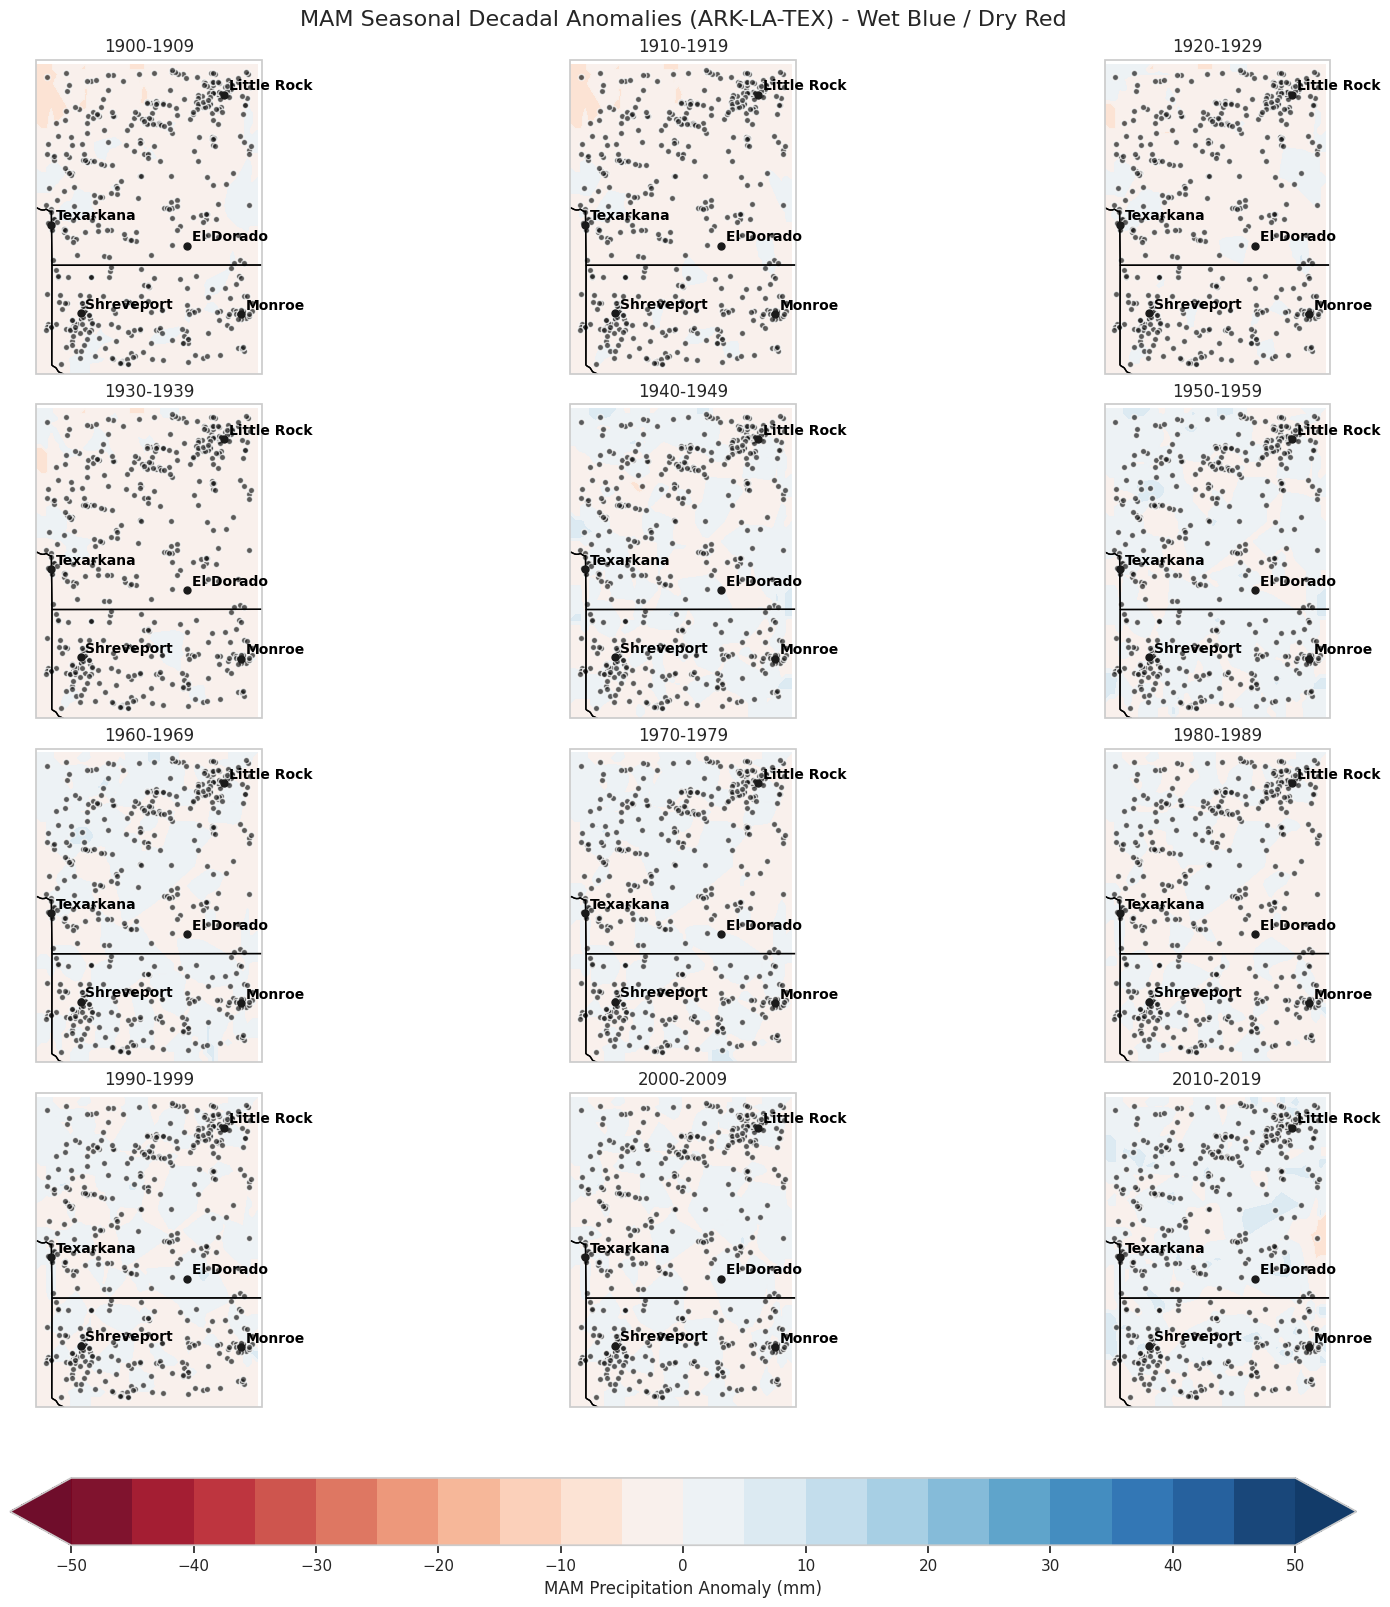

In [13]:
import matplotlib.colors as mcolors

class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint
        rescaled = np.ma.masked_array((result - midpoint) / (vmax - vmin) + 0.5)
        return rescaled

# Plotting MAM Seasonal Decadal Anomalies
n_cols = 3
num_decades = len(decade_labels)
n_rows = int(np.ceil(num_decades / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows),
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         constrained_layout=True)
axes = axes.flatten()

max_anom = 50 
levels = np.arange(-max_anom, max_anom+5, 5)  
cmap = plt.get_cmap('RdBu') 
norm = MidpointNormalize(vmin=-max_anom, vmax=max_anom, midpoint=0)

for ax, decade in zip(axes, decade_labels):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    cf = ax.contourf(grid_lon, grid_lat, seasonal_interp[decade],
                     levels=levels, cmap=cmap, norm=norm, extend='both', alpha=0.95)

    for station_id in seasonal_anomalies.index:
        row = region_stations[region_stations['ID'] == station_id]
        ax.scatter(row['LON'].values[0], row['LAT'].values[0],
                   s=20, c='k', edgecolor='white', alpha=0.7)

    for city, (latc, lonc) in major_cities.items():
        ax.plot(lonc, latc, 'ko', markersize=5)
        ax.text(lonc+0.05, latc+0.05, city, fontsize=10, weight='bold', color='black')

    ax.set_title(f"{decade}", fontsize=12)

for ax in axes[num_decades:]:
    ax.axis('off')

cbar = fig.colorbar(cf, ax=axes[:num_decades], orientation='horizontal', pad=0.05, fraction=0.05)
cbar.set_label(f"{season} Precipitation Anomaly (mm)", fontsize=12)
cbar.set_ticks(np.arange(-max_anom, max_anom+10, 10))  

fig.suptitle(f"{season} Seasonal Decadal Anomalies (ARK-LA-TEX) - Wet Blue / Dry Red", fontsize=16)
plt.show()


In [14]:
import xarray as xr
import numpy as np

# Annual anomalies 
annual_anom = precip_all.resample('A').sum()
annual_anom = annual_anom - annual_anom.mean()

annual_clean = annual_anom.astype(float)
annual_da = xr.DataArray(
    annual_clean.values,
    dims=("time", "space"),
    coords={
        "time": annual_clean.index.values,
        "space": annual_clean.columns.values
    }
)
print("Annual DA shape:", annual_da.shape)

# Seasonal anomalies 
def get_season(month):
    if month in [12,1,2]: return 'DJF'
    elif month in [3,4,5]: return 'MAM'
    elif month in [6,7,8]: return 'JJA'
    elif month in [9,10,11]: return 'SON'

season = 'MAM'
seasonal_precip = precip_all.copy()
seasonal_precip['Season'] = seasonal_precip.index.month.map(get_season)
seasonal_precip['Year'] = seasonal_precip.index.year
seasonal_precip.loc[seasonal_precip.index.month==12,'Year'] += 1

decade_labels = [f"{start}-{start+9}" for start in range(1900,2020,10)]
seasonal_decade_means = pd.DataFrame(index=region_stations['ID'], columns=decade_labels)

for start in range(1900, 2020, 10):
    end = start + 9
    subset = seasonal_precip.loc[f"{start}-01-01":f"{end}-12-31"]
    season_subset = subset[subset['Season']==season].drop(columns=['Season','Year'])
    seasonal_decade_means[f"{start}-{end}"] = season_subset.sum() / len(season_subset.columns)

overall_mean = seasonal_decade_means.mean(axis=1)
seasonal_anomalies = seasonal_decade_means.subtract(overall_mean, axis=0)

seasonal_values_T = seasonal_anomalies.values.T  # decades x stations
seasonal_da = xr.DataArray(
    seasonal_values_T,
    dims=("time", "space"),
    coords={
        "time": seasonal_anomalies.columns.values,
        "space": seasonal_anomalies.index.values
    }
)
print("Seasonal DA shape:", seasonal_da.shape)

seasonal_da = seasonal_da.fillna(0)
valid_space = seasonal_da.std(dim='time') > 0
seasonal_da = seasonal_da.sel(space=valid_space)


Annual DA shape: (154, 495)
Seasonal DA shape: (12, 495)


In [19]:
def compute_eofs(dataarray, n_modes=3):
    X = dataarray.values - np.mean(dataarray.values, axis=0)
    
    U, S, VT = np.linalg.svd(X, full_matrices=False)
    pcs = U[:, :n_modes] * S[:n_modes]
    eofs = VT[:n_modes, :]
    variance_fractions = (S**2)/np.sum(S**2)
    return eofs, pcs, variance_fractions

annual_eofs, annual_pcs, annual_var_frac = compute_eofs(annual_da, n_modes=3)
print("Annual EOF variance fractions:", annual_var_frac[:3])

seasonal_eofs, seasonal_pcs, seasonal_var_frac = compute_eofs(seasonal_da, n_modes=3)
print("Seasonal EOF variance fractions:", seasonal_var_frac[:3])


Annual EOF variance fractions: [0.35292005 0.21350008 0.09041811]
Seasonal EOF variance fractions: [0.41511584 0.28230768 0.13397321]


In [16]:
from scipy.interpolate import griddata
import numpy as np

# Annual EOFs
station_ids_annual = annual_da.space.values
region_stations_indexed_annual = region_stations.set_index('ID').reindex(station_ids_annual)
lons_annual = region_stations_indexed_annual['LON'].values
lats_annual = region_stations_indexed_annual['LAT'].values

valid_mask_annual = ~np.isnan(lons_annual) & ~np.isnan(lats_annual)
lons_valid_annual = lons_annual[valid_mask_annual]
lats_valid_annual = lats_annual[valid_mask_annual]

def interp_eof_annual(eof_values):
    eof_valid = eof_values[valid_mask_annual]
    return griddata(
        points=(lons_valid_annual, lats_valid_annual),
        values=eof_valid,
        xi=(grid_lon, grid_lat),
        method='cubic'
    )

annual_eof_grids = [interp_eof_annual(annual_eofs[i,:]) for i in range(3)]

# Seasonal EOFs
station_ids_seasonal = seasonal_da.space.values
region_stations_indexed_seasonal = region_stations.set_index('ID').reindex(station_ids_seasonal)
lons_seasonal = region_stations_indexed_seasonal['LON'].values
lats_seasonal = region_stations_indexed_seasonal['LAT'].values

valid_mask_seasonal = ~np.isnan(lons_seasonal) & ~np.isnan(lats_seasonal)
lons_valid_seasonal = lons_seasonal[valid_mask_seasonal]
lats_valid_seasonal = lats_seasonal[valid_mask_seasonal]

def interp_eof_seasonal(eof_values):
    eof_valid = eof_values[valid_mask_seasonal]
    return griddata(
        points=(lons_valid_seasonal, lats_valid_seasonal),
        values=eof_valid,
        xi=(grid_lon, grid_lat),
        method='cubic'
    )

seasonal_eof_grids = [interp_eof_seasonal(seasonal_eofs[i,:]) for i in range(3)]

print("Annual EOF grids shape:", [g.shape for g in annual_eof_grids])
print("Seasonal EOF grids shape:", [g.shape for g in seasonal_eof_grids])


Annual EOF grids shape: [(64, 46), (64, 46), (64, 46)]
Seasonal EOF grids shape: [(64, 46), (64, 46), (64, 46)]


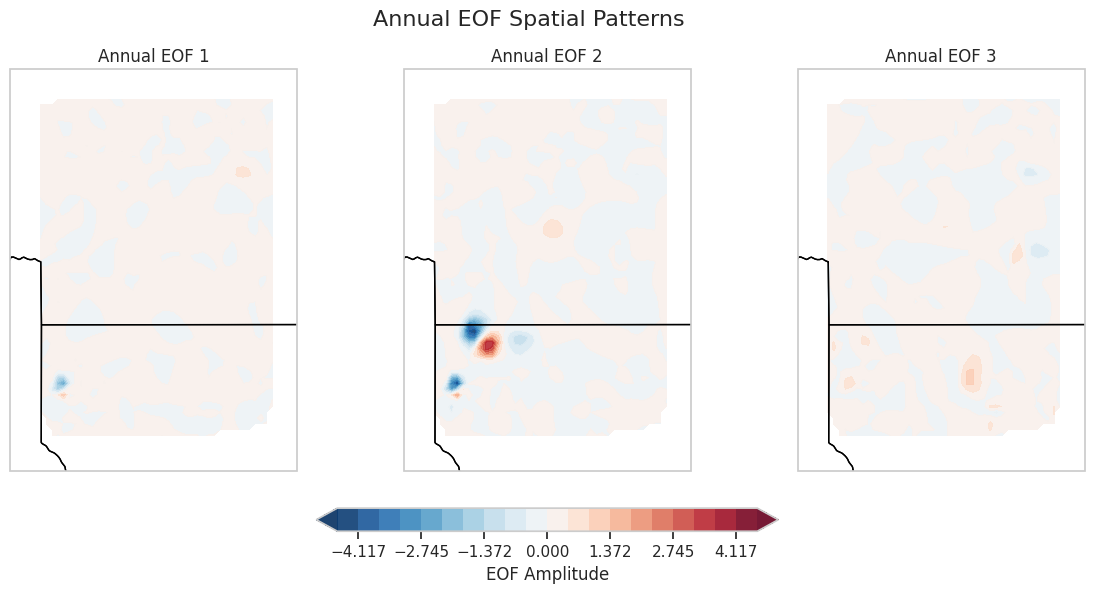

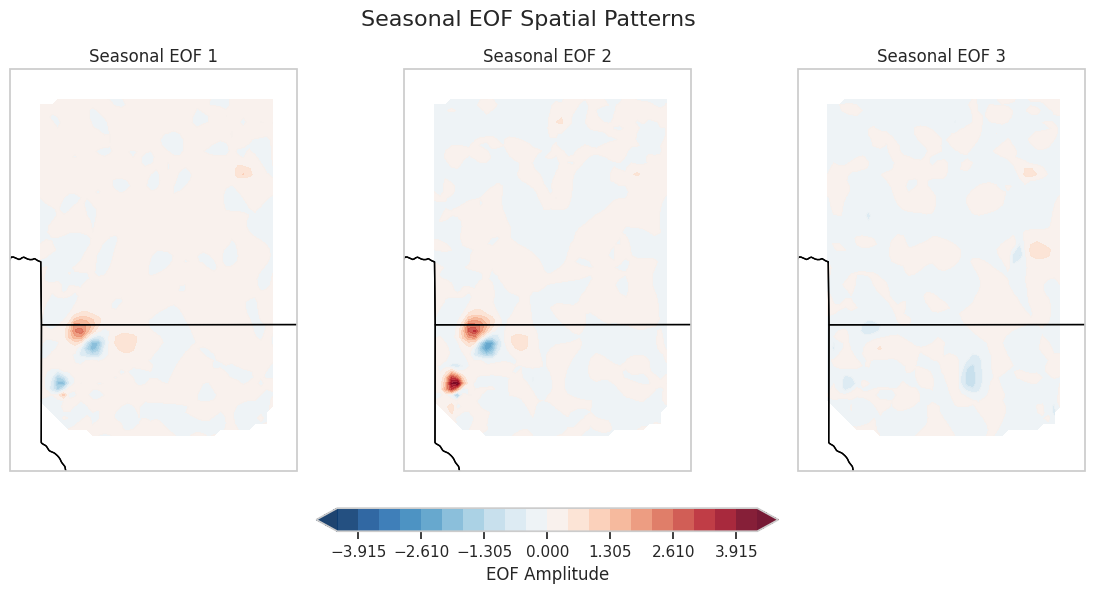

In [17]:
# Plotting EOF spatial patterns

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint
        rescaled = np.ma.masked_array((result - midpoint) / (vmax - vmin) + 0.5)
        return rescaled

cmap = plt.get_cmap('RdBu_r')  

def plot_eof_grids(eof_grids, title_prefix):
    n_eofs = len(eof_grids)
    fig, axes = plt.subplots(1, n_eofs, figsize=(5*n_eofs, 6),
                             subplot_kw={'projection': ccrs.PlateCarree()},
                             gridspec_kw={'wspace':0.05})
    if n_eofs == 1:
        axes = [axes]

    vmax = max(np.nanmax(np.abs(g)) for g in eof_grids)
    norm = MidpointNormalize(vmin=-vmax, vmax=vmax, midpoint=0)

    for i, ax in enumerate(axes):
        grid = eof_grids[i]
        cf = ax.contourf(grid_lon, grid_lat, grid,
                         levels=np.linspace(-vmax, vmax, 21),
                         cmap=cmap, norm=norm, extend='both', alpha=0.9)
        ax.add_feature(cfeature.STATES, edgecolor='black')
        ax.add_feature(cfeature.COASTLINE)
        ax.set_title(f"{title_prefix} EOF {i+1}")

    cbar = fig.colorbar(cf, ax=axes, orientation='horizontal', pad=0.08, fraction=0.05)
    cbar.set_label('EOF Amplitude', fontsize=12)
    plt.suptitle(f"{title_prefix} EOF Spatial Patterns", fontsize=16)
    plt.show()

# Annual EOFs
plot_eof_grids(annual_eof_grids, "Annual")

# Seasonal EOFs
plot_eof_grids(seasonal_eof_grids, "Seasonal")


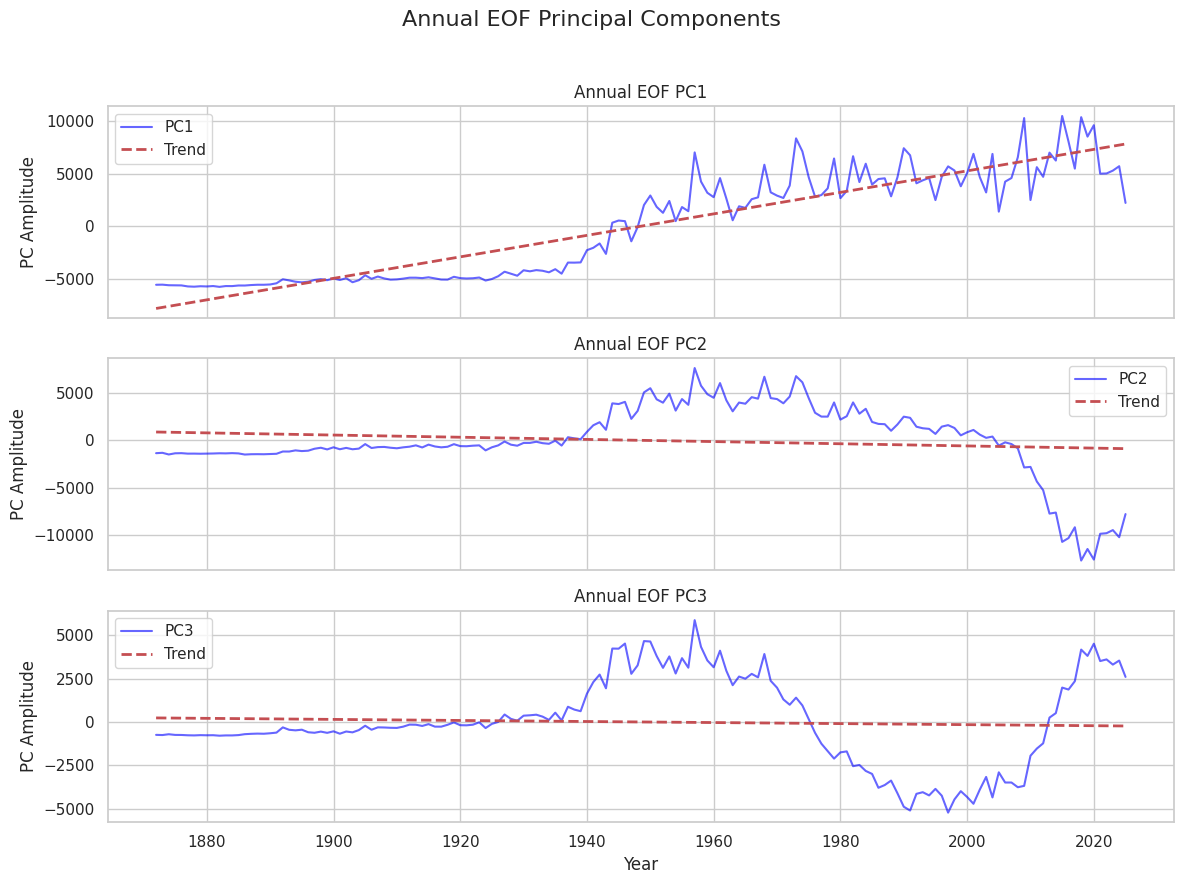

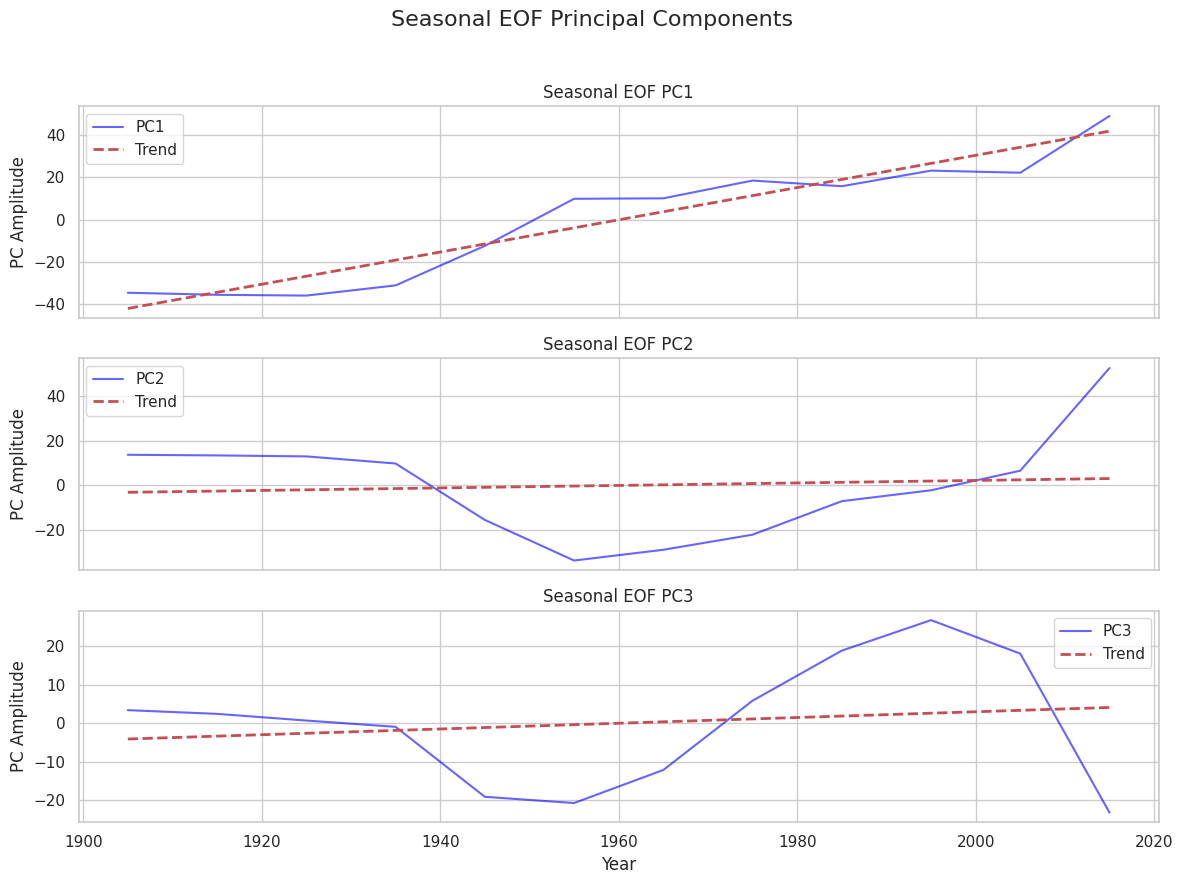

In [18]:
def plot_eof_pcs(pcs, years, title_prefix):
    """
    pcs: (time x n_modes)
    years: numeric or strings (e.g., '1900-1909') -> converted to float for trend
    """
    if np.issubdtype(years.dtype, np.datetime64):
        years_num = pd.to_datetime(years).year.values.astype(float)
    elif np.issubdtype(years.dtype, np.number):
        years_num = np.array(years, dtype=float)
    else:
 
        years_num = np.array([float(s.split('-')[0]) + 5 for s in years])  # midpoint of decade

    n_pcs = pcs.shape[1]
    fig, axes = plt.subplots(n_pcs, 1, figsize=(12, 3*n_pcs), sharex=True)
    if n_pcs == 1:
        axes = [axes]

    for i in range(n_pcs):
        ax = axes[i]
        y = pcs[:, i]
        ax.plot(years_num, y, color='blue', alpha=0.6, label=f'PC{i+1}')

        X = years_num.reshape(-1, 1)
        model = LinearRegression()
        model.fit(X, y)
        trend = model.predict(X)
        ax.plot(years_num, trend, 'r--', linewidth=2, label='Trend')

        ax.set_ylabel('PC Amplitude')
        ax.set_title(f'{title_prefix} EOF PC{i+1}')
        ax.grid(True)
        ax.legend()

    axes[-1].set_xlabel('Year')
    plt.suptitle(f'{title_prefix} EOF Principal Components', fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()


# Annual PCs
plot_eof_pcs(annual_pcs, annual_da.time.values, "Annual")

# Seasonal PCs (decades)
plot_eof_pcs(seasonal_pcs, seasonal_da.time.values, "Seasonal")


## Summary

- **Data Source:** NOAA Global Historical Climatology Network Daily (GHCN-D) [https://doi.org/10.7289/V5D21VHZ].  
- **Annual & Seasonal Trends:** Annual totals show a gradual increase. Spring (MAM) exhibits the highest variability.  
- **Rolling Variability:** 10-year rolling standard deviations highlight alternating periods of higher and lower variability.  
- **Spatial Anomalies:** Decadal maps show alternating wet and dry periods, with increasing spatial heterogeneity in recent decades.  
- **EOF Analysis:**  
  - **EOFs (Empirical Orthogonal Functions):** Spatial patterns that describe dominant modes of variability.  
  - **PCs (Principal Components):** Time series associated with each EOF, showing how strongly that spatial pattern is expressed at different times.  
  - **Annual EOFs:** EOF1 explains ~35% of variance (basin-wide wet/dry mode), EOF2 ~21% (regional contrasts), EOF3 ~9% (localized variability).  
  - **Seasonal EOFs (MAM):** EOF1 explains ~41% of variance (dominant spring mode), EOF2 ~28% (spatial contrasts), EOF3 ~13% (localized spring variability).  
- **Interpretation:** EOFs and PCs together show that precipitation variability is not uniform — some modes represent widespread changes across the region, while others capture dipole or localized signals. PCs reveal how these modes evolve over time, with EOF1 intensifying in recent decades.

Overall, precipitation in the ARK-LA-TEX region is increasing and becoming more variable, especially in spring. EOF analysis confirms that variability arises from both basin-wide and localized processes.